# Requirements

In [1]:
# Install Pytorch
#!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
# Install detectron2
#!pip install 'git+https://github.com/facebookresearch/detectron2.git'
# Install other
#!pip install pandas opencv-python-headless mlflow

# Imports

In [2]:
import torch
print('Torch Version: {}'.format(torch.__version__))
import torchvision
print('TorchVision Version: {}'.format(torchvision.__version__))
# import some common libraries
import numpy as np
import pandas as pd
import os, json, cv2, shutil, string, pytz
import matplotlib.pyplot as plt
from datetime import datetime, timezone
%matplotlib inline  
import random
import json
import re
import mlflow
from PIL import Image
from io import BytesIO
from detectron2.utils.visualizer import ColorMode
from pylab import *
from datetime import datetime 


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import get_detection_dataset_dicts, DatasetMapper, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.logger import setup_logger, log_every_n_seconds
from detectron2.data import transforms as T
from detectron2.engine import HookBase
from detectron2.data import build_detection_test_loader


import torch
device = torch.device('cuda')
print('Device Properties: {}'.format(torch.cuda.get_device_properties(device)))
print('Memory Allocated: {}'.format(torch.cuda.memory_allocated(device)))
print('Memory Allocated: {}'.format(torch.cuda.memory_reserved(device)))

if torch.cuda.is_available():
    print('Module torch.cuda available from {}'.format(torch.cuda))

Torch Version: 2.0.0+cu118
TorchVision Version: 0.15.1+cu118
Device Properties: _CudaDeviceProperties(name='GRID A100D-7-80C MIG 7g.75gb', major=8, minor=0, total_memory=81915MB, multi_processor_count=98)
Memory Allocated: 0
Memory Allocated: 0
Module torch.cuda available from <module 'torch.cuda' from '/home/jovyan/.local/lib/python3.10/site-packages/torch/cuda/__init__.py'>


# Benchmarck Configs

In [3]:
# All available at https://github.com/facebookresearch/detectron2/tree/main/configs/COCO-Detection
# In total, there are 18 different architectures, but if time is tight, we can restrict to the fastercnn* group
archs = ['faster_rcnn_R_101_C4_3x.yaml', 'faster_rcnn_R_101_DC5_3x.yaml', 'faster_rcnn_R_101_FPN_3x.yaml', 'faster_rcnn_R_50_C4_1x.yaml',
'faster_rcnn_R_50_C4_3x.yaml', 'faster_rcnn_R_50_DC5_1x.yaml', 'faster_rcnn_R_50_DC5_3x.yaml', 'faster_rcnn_R_50_FPN_1x.yaml',
'faster_rcnn_R_50_FPN_3x.yaml', 'faster_rcnn_X_101_32x8d_FPN_3x.yaml', 'retinanet_R_101_FPN_3x.yaml', 'retinanet_R_50_FPN_1x.yaml',
'retinanet_R_50_FPN_3x.yaml', 'rpn_R_50_C4_1x.yaml', 'rpn_R_50_FPN_1x.yaml']

# [8, 16, 64, 132]
IMS_PER_BATCH = 8

# [1000, 2000]
MAX_ITER = 1000

module_arch = 'COCO-Detection/' + archs[4]

# General Config 

In [4]:
Case_Study = 'chunks' #Can be one of ('chunks', 'whole')

exp_name = 'Detectron2_Chunks' +  module_arch.split('/')[1].split('.')[0]
BATCH_SIZE_PER_IMAGE = 32

# Add other configurations for training (hyperparameters and augmentations)
RumexAugmentations = [
    T.RandomBrightness(0.9, 1.1),
    T.RandomContrast(0.5, 2),
    T.RandomSaturation(0.5, 2),
    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    T.RandomFlip(prob=0.5, horizontal=False, vertical=True)
    ]
BASE_LR = 0.00025  # pick a good LR 
NUM_IMAGES_INF_LOG = 20

# Data and Annotations Configuration

In [5]:
# Set up logging
setup_logger()
mount_point = './images'

In [6]:
# As of April 2023, these datasets are available with annotated chunks
# 20221010_HaldenNord_S_25_F_60_O_sama_ID1 ==> Frames to be fixed by Michael
# 20220823_HaldenSued_S_10_F_50_O_stra_ID1
# 20220901_HaldenNord_S_10_F_50_O_sama_ID1

dataset_name = '20220823_HaldenSued_S_10_F_50_O_stra_ID1' # Tested for visu ~ 6000 instances
dataset_dir = os.path.join(mount_point, dataset_name)
if Case_Study == 'chunks':
    image_dir = os.path.join(dataset_dir, '1_images/Chunks')
else:
    image_dir = os.path.join(dataset_dir, '1_images')

annotations_dir = os.path.join(dataset_dir, '3_annotations')

print('Available Datasets:')
DataSets = [d for d in os.listdir(mount_point) if os.path.isdir(os.path.join(mount_point, d))]
DataSets

Available Datasets:


['20220823_HaldenSued_S_10_F_50_O_stra_ID1']

In [7]:
output_train = os.path.join(annotations_dir, 'train_chuncks.json')
output_val = os.path.join(annotations_dir, 'val_chuncks.json')
output_test = os.path.join(annotations_dir, 'test_chuncks.json')

classes = [ "rumex_plant"]
partitions = ['train_chuncks', 'test_chuncks', 'val_chuncks']

for partition in partitions:
    if partition not in MetadataCatalog.list():
        ann_file = os.path.join(annotations_dir, partition + '.json')
        register_coco_instances(partition, {}, ann_file, image_dir)
    MetadataCatalog.get(partition).set(thing_classes=classes)

# Metadata Configuration

In [8]:
classes = ["rumex_plant"]
metadata = MetadataCatalog.get('rumex_train').set(thing_classes=classes)
for partition in partitions:
    print(MetadataCatalog.get(partition))

Metadata(name='train_chuncks', json_file='./images/20220823_HaldenSued_S_10_F_50_O_stra_ID1/3_annotations/train_chuncks.json', image_root='./images/20220823_HaldenSued_S_10_F_50_O_stra_ID1/1_images/Chunks', evaluator_type='coco', thing_classes=['rumex_plant'])
Metadata(name='test_chuncks', json_file='./images/20220823_HaldenSued_S_10_F_50_O_stra_ID1/3_annotations/test_chuncks.json', image_root='./images/20220823_HaldenSued_S_10_F_50_O_stra_ID1/1_images/Chunks', evaluator_type='coco', thing_classes=['rumex_plant'])
Metadata(name='val_chuncks', json_file='./images/20220823_HaldenSued_S_10_F_50_O_stra_ID1/3_annotations/val_chuncks.json', image_root='./images/20220823_HaldenSued_S_10_F_50_O_stra_ID1/1_images/Chunks', evaluator_type='coco', thing_classes=['rumex_plant'])


# Visualizing an randomly chosen image with all its annotations

WARNING [05/03 14:30:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 14:30:01 d2.data.datasets.coco]: Loaded 24944 images in COCO format from ./images/20220823_HaldenSued_S_10_F_50_O_stra_ID1/3_annotations/train_chuncks.json
[05/03 14:30:01 d2.data.build]: Removed 23937 images with no usable annotations. 1007 images left.


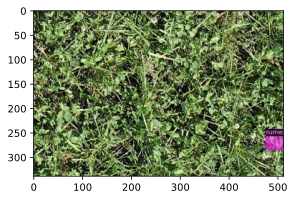

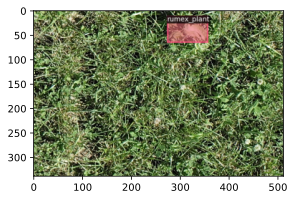

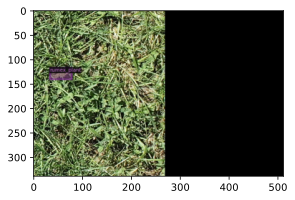

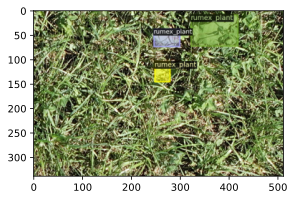

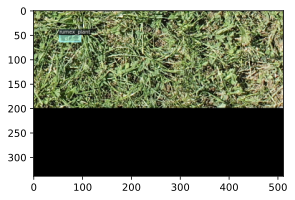

In [9]:
# Verify if the data is correct by plotting a random image
from random import sample
dataset_dicts = get_detection_dataset_dicts('train_chuncks')
for d in sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    if img is not None:
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
        out = visualizer.draw_dataset_dict(d)
        plt.figure(figsize = (6, 3))
        plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print('failed to load image')

In [11]:
# Creating the output folder

output_folder = 'results/' + module_arch.split('/')[-1].split('.')[0] + '_' +  str(Case_Study) + '_IPB_' + str(IMS_PER_BATCH) + '_MI_' + str(MAX_ITER) + '_BSPI_'+ str(BATCH_SIZE_PER_IMAGE)


In [15]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(module_arch))

cfg.DATASETS.TRAIN = ('train_chuncks',) 
cfg.DATASETS.VAL = ('val_chuncks',)
cfg.DATASETS.TEST = ('test_chuncks',) 

#cfg.INPUT.MAX_TRAIN_SIZE = MAX_IMG_SIZE
cfg.DATALOADER.NUM_WORKERS =  16 # Depend on # of CPU cores
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(module_arch)  # Initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = IMS_PER_BATCH  # Batch size of (default = 8)
cfg.SOLVER.BASE_LR = BASE_LR  # pick a good LR
cfg.SOLVER.MAX_ITER = MAX_ITER    # Number of iterations
cfg.SOLVER.STEPS = []         # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE_PER_IMAGE
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = output_folder
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print('The model will be saved in {}'.format(cfg.OUTPUT_DIR))
#print('The model has the following structure: {}'.format(cfg))

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

The model will be saved in results/faster_rcnn_R_50_C4_3x_chunks_IPB_8_MI_1000_BSPI_32


In [17]:
os.cpu_count()

16

In [18]:
class RumexTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=RumexAugmentations)
        return build_detection_train_loader(cfg, mapper=mapper)


In [ ]:
start_time_training = datetime.now()

trainer = RumexTrainer(cfg) 
trainer.resume_or_load(resume=False)
results = trainer.train()

# Record end time
end_time_training = datetime.now()

# Calculate time taken
elapsed_time = end_time_training - start_time_training
elapsed_minutes_training = int(elapsed_time.total_seconds() / 60)

[05/03 14:32:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[05/03 14:33:23 d2.engine.train_loop]: Starting training from iteration 0


/home/jovyan/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Configuring the predictor
The threshold reflects the permissivity to accept an object or not. The higher the thresholed, the lower the number of detected objects.

In [ ]:
#choose an output file
experiment_directory = output_folder
cfg.MODEL.WEIGHTS = os.path.join(output_folder, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Inference on the test dataset and determining the performance metrics

In [ ]:
start_time_inference = datetime.now()

evaluator = COCOEvaluator('test_chuncks', cfg, False, output_dir=output_folder)
val_loader = build_detection_test_loader(cfg, 'test_chuncks')
inf_results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Record end time
end_time_inference = datetime.now()

# Calculate time taken
elapsed_time = end_time_inference - start_time_inference
elapsed_minutes_inference = int(elapsed_time.total_seconds() / 60)


In [ ]:
results_dict = {
    "AP": inf_results['bbox']['AP'],
    "AP50": inf_results['bbox']['AP50'],
    "AP75": inf_results['bbox']['AP75'],
    "APs": inf_results['bbox']['APs'],
    "APm": inf_results['bbox']['APm'],
    "APl": inf_results['bbox']['APl']}
metrics_file = os.path.join(output_folder, 'ap_metrics.json')
with open(metrics_file, 'w') as fp:
    json.dump(results_dict, fp)


In [ ]:
# Create dictionary with results for time spent
time_spent = {
    "start_time_training": start_time_training.strftime("%Y-%m-%d %H:%M:%S"),
    "end_time_training": end_time_training.strftime("%Y-%m-%d %H:%M:%S"),
    "elapsed_minutes_training": elapsed_minutes_training,
    "start_time_inference": start_time_inference.strftime("%Y-%m-%d %H:%M:%S"),
    "end_time_inference": end_time_inference.strftime("%Y-%m-%d %H:%M:%S"),
    "elapsed_minutes_inference": elapsed_minutes_inference

}
time_file = os.path.join(output_folder, 'time_spent.json')
with open(time_file, 'w') as fp:
    json.dump(time_spent, fp)

# Plotting some predictions

## Note, run this with images saved locally, once done move them to experiments

In [ ]:
inf_path = os.path.join(output_folder, 'sample_inference_images')

if not os.path.exists(inf_path):
    os.makedirs(inf_path)
    print(f"{inf_path} created!")
else:
    print(f"{inf_path} already exists!")
    
    
test_dict = get_detection_dataset_dicts('test_chuncks')

for d in test_dict[0:NUM_IMAGES_INF_LOG]:
    im = cv2.imread(d["file_name"])
    print(im[:, :, ::-1].shape)
    im_string = d["file_name"].split('/')[-1]

    print('Processing the image {}'.format(im_string))

    #plt.figure(figsize = (15, 30))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 5))

    #Visualizing the ground truth image
    ground_truth_visualizer = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.5)
    ground_truth_image = ground_truth_visualizer.draw_dataset_dict(d)

    ax1.imshow(cv2.cvtColor(ground_truth_image.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image \n'+ im_string , loc='center', fontsize=8)
    ax1.set_xticks([])
    ax1.set_yticks([])
    #plt.show()
    
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    pred_visualizer = Visualizer(im[:, :, ::-1],
                    metadata=metadata, 
                    scale=0.5)
    pred_image = pred_visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    #print(outputs["instances"].to("cpu"))
    
    ax2.imshow(cv2.cvtColor(pred_image.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    ax2.set_title('Model output', loc='center', fontsize=8)
    ax2.set_xticks([])
    ax2.set_yticks([])

    fig_name = im_string.split('.')[0] + '_TH_' + str(int(cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST*100)) + '.png' #Include the threshold in the naming
    #print(fig_name)
    fig_name = os.path.join(inf_path, fig_name)
    savefig(fig_name, dpi = 300)
    
    plt.show()


# Plotting results and metrics

In [ ]:
json_file_name = output_folder + '/metrics.json'
parsed=[]

#with open(json_file_name) as f:
df = pd.read_json(json_file_name, lines=True )

In [ ]:

fig = figure(figsize=(8,6), dpi=300)

y1 = fig.add_subplot(111)
y1.set_xlabel('Iterations')
y2 = y1.twinx()
# Plotting the total_loss
y1.plot(df['iteration'], df['total_loss'], color="darkslategray", linewidth=0.3,linestyle="-",label='total_loss')
# Plotting the box regression loss
y1.plot(df['iteration'], df['loss_box_reg'], color="green", linewidth=0.3,linestyle="-",label='loss_box_reg')
# Plotting the class loss
y1.plot(df['iteration'], df['loss_cls'], color="blue", linewidth=0.3,linestyle="-",label='loss_class')
# Plotting the loss_rpn_cls
y1.plot(df['iteration'], df['loss_rpn_cls'], color="orange", linewidth=0.3,linestyle="-",label='loss_rpn_cls')
# Plotting the false_negative
y1.plot(df['iteration'], df['loss_rpn_cls'], color="black", linewidth=0.3,linestyle="-",label='loss_rpn_cls')
# Plotting the loss_rpn_loc
y1.plot(df['iteration'], df['loss_rpn_loc'], color="goldenrod", linewidth=0.3,linestyle="-",label='loss_rpn_loc')
# Plotting the learning rate
y2.set_ylim(0,max(df['lr'])/0.8)
y2.plot(df['iteration'], df['lr'], color="purple", linewidth=1.0, linestyle="-",label='lr')
y2.set_ylabel('lr')
y2.legend(loc = 2)
y1.legend(loc = 1)
fig_name = output_folder + '/losses.png'
savefig(fig_name)
#show()
#plt.show()


In [ ]:
fig = figure(figsize=(8,6), dpi=300)

y1 = fig.add_subplot(111)
y1.set_xlabel('Iterations')

# Plotting the roi_head/num_bg_samples
y1.plot(df['iteration'], df['roi_head/num_bg_samples'], color="red", linewidth=0.3,linestyle="-",label='roi_head/num_bg_samples')



# Plotting the roi_head/num_fg_samples
y1.plot(df['iteration'], df['roi_head/num_fg_samples'], color="blue", linewidth=0.3,linestyle="-",label='roi_head/num_fg_samples')



# Plotting the false_negative
y1.plot(df['iteration'], df['rpn/num_neg_anchors'], color="black", linewidth=0.3,linestyle="-",label='rpn/num_neg_anchors')



# Plotting the false_negative
y1.plot(df['iteration'], df['rpn/num_pos_anchors'], color="orange", linewidth=0.3,linestyle="-",label='rpn/num_pos_anchors')


y1.legend(loc = 1)
fig_name = output_folder + '/numbers.png'
savefig(fig_name)
#show()
#plt.show()



In [ ]:
fig = figure(figsize=(8,6), dpi=300)

y1 = fig.add_subplot(111)
y1.set_xlabel('Iterations')

# Plotting the fast_rcnn/fg_cls_accuracy
y1.plot(df['iteration'], df['fast_rcnn/fg_cls_accuracy'], color="cornflowerblue", linewidth=0.3,linestyle="-",label='fast_rcnn/fg_cls_accuracy')

# Plotting the class accuracy
y1.plot(df['iteration'], df['fast_rcnn/cls_accuracy'], color="red", linewidth=0.3,linestyle="-",label='cls_accuracy')

# Plotting the false_negative
y1.plot(df['iteration'], df['fast_rcnn/false_negative'], color="purple", linewidth=0.3,linestyle="-",label='false_negative')


y1.legend(loc = 1)
fig_name = output_folder + '/accuracies.png'
savefig(fig_name)
#show()
#plt.show()


